Based on https://arxiv.org/abs/1508.06576 <br>
Dataset: https://files.fast.ai/data/imagenet-sample-train.tar.gz 

In [ ]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

#For deterministic optimization 
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

In [2]:
#To limit GPU memory usage as tensorflow uses all of the memory by default as 
#should be the case in production but not so much during experimentation. 
limit_mem()

Format in tensorflow batch_sizexheightxwidthxchannels 

In [3]:
path = 'data/styleTransfer/imagenet/train/'
spath = 'data/styleTransfer/imagenet/'

## Preview an image

In [4]:
fnames = glob.glob(path+'**/*.JPEG', recursive=True)

In [5]:
n = len(fnames); n

19439

In [6]:
fn = fnames[20]

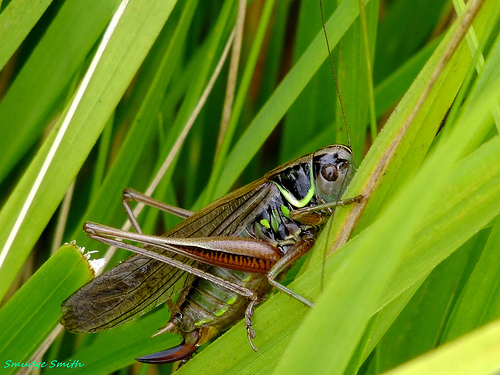

In [7]:
img=Image.open(fnames[25]); img

## Preprocess and deprocess Functions 
in conformance with what the authors of VGG did.
1. Subtract mean of each channel
2. Reverse order of RGB to BGR

In [8]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [9]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [10]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape; shp

(1, 375, 500, 3)

## VGG model

vgg_Avg doess't use maxpooling because maxpooling throws away information which is adverserial for a generative model. Instead, average pooling is used as it doesn't throw away much information. 

In [11]:
model = VGG16_Avg(include_top=False)

Defining a helper class that takes in a function to split and return separated loss and gradient outputs which is required for the determiistic optimizer.
Takes in as input the function and shape of the image.  

In [12]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
       
    #x is the input image on which loss is calculated
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [13]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'{spath}/results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

In [14]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

In [15]:
def gram_matrix(x):
    #Each row is to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [16]:
def style_loss(x, targ): return  K.mean(metrics.mse(gram_matrix(x), gram_matrix(targ)))

## Recreate image

Grabbing one of the last layers of the convolution model, retrieving the 

In [ ]:
layer = model.get_layer('block5_conv3').output

Calculating target activations for the above layer

In [ ]:
#Creating a new model that takes the original input and produces an output resembling 
#the layer defined below. 
layer_model = Model(model.input, layer)
#Create a keras tensorflow symbolic variable that holds the activations of block 5 conv 1
targ = K.variable(layer_model.predict(img_arr))

Defining a computation graph of the kind of model we need.

In [ ]:
#Here, the loss function we minimize is between the already declared targ variable containing 
#activations of a given image and a symbolic layer which will take in images
loss = K.mean(metrics.mse(layer, targ)) #loss defines f(content)
#Note that that optimisation is on the input to that model which is the img rather than on weights w
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
#An evaluator function is required because SGD isn't a plausible choice here (nothing stochastic in the date)
evaluator = Evaluator(fn, shp)


Solve image optimize the loss function defined above with a deterministic approach using a line search implemented with sklearn's fmin_l_bfgs_b function. 

In [ ]:
#Generate a random image
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

In [ ]:
iterations=10

In [ ]:
x = solve_image(evaluator, iterations, x)

In [ ]:
Image.open(spath + 'results/res_at_iteration_9.png')

## Visualizing progress


In [ ]:
from IPython.display import HTML
from matplotlib import animation, rc

In [ ]:
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(f'{spath}results/res_at_iteration_{i}.png'))

In [ ]:
anim = animation.FuncAnimation(fig, animate, frames=10, interval=500)
HTML(anim.to_html5_video())

___________________________________________________________________________________________

In [85]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

## Recreate style

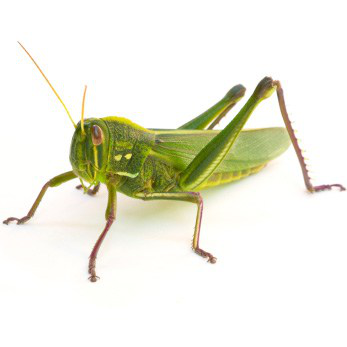

In [59]:
style = Image.open(spath+'/data.jpg')
style = style.resize(np.divide(style.size,1).astype('int32')); style

In [60]:
shp

(1, 375, 474, 3)

In [61]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape

Using multiple layers to calculate the loss function

In [63]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [64]:
layers_model = Model(model.input, layers)
#Targs now contains convolution activations of multiple layers
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

In [65]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

In [66]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

In [67]:
iterations=10
x = rand_img(shp); x.shape

(1, 347, 347, 3)

In [68]:
x = solve_image(evaluator, iterations, x)

Current loss value: 43841.578125
Current loss value: 12307.7695312
Current loss value: 744.320251465
Current loss value: 220.952316284
Current loss value: 137.565658569
Current loss value: 97.8992156982
Current loss value: 78.2519836426
Current loss value: 65.4803237915
Current loss value: 55.8295135498
Current loss value: 48.2677993774


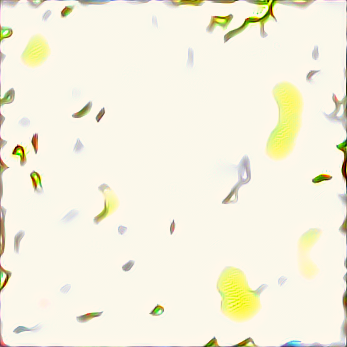

In [69]:
Image.open(spath + 'results/res_at_iteration_9.png')

## Style Transfer

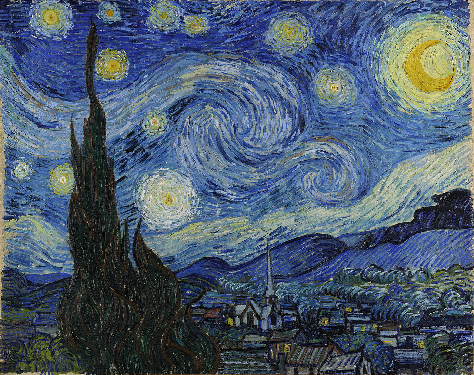

In [86]:
style = Image.open(spath+'/data1.jpg')
style = style.resize(np.divide(style.size,2.7).astype('int32')); style

In [87]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

In [88]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape; shp

(1, 375, 474, 3)

Normalise sizes of content and style image. 

(1, 375, 474, 3)

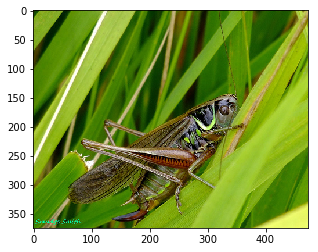

In [89]:
w,h = style.size
src = img_arr[:,:h,:w]
plot_arr(src); shp=src.shape; shp

In [90]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [91]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [92]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

In [93]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

Create a loss function that combines style loss and content loss. 

In [99]:
loss = sum(style_loss(l1[0], l2[0])#*w
           for l1,l2 in zip(style_layers, style_targs))#, style_wgts))
loss += K.mean(metrics.mse(content_layer, content_targ)/10)
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [100]:
evaluator = Evaluator(transfer_fn, shp)

In [101]:
iterations=10
x = src

In [102]:
x = solve_image(evaluator, iterations, x)

Current loss value: 1796.20141602
Current loss value: 986.484924316
Current loss value: 733.707885742
Current loss value: 627.434814453
Current loss value: 562.504943848
Current loss value: 524.230834961
Current loss value: 500.485717773
Current loss value: 481.426116943
Current loss value: 469.408538818
Current loss value: 456.949310303


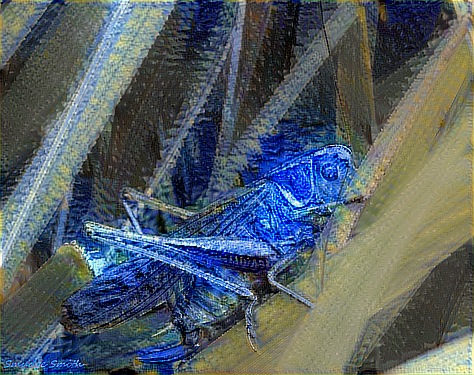

In [103]:
Image.open(spath + 'results/res_at_iteration_9.png')